<a href="https://colab.research.google.com/github/MasaAsami/LTsandox/blob/main/notebooks/stream_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title google colabとカメラを繋ぐ呪文 { display-mode: "form" }
import base64
import html
import io
import time

from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2

def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [52]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam
    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)

    return image_array

In [3]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


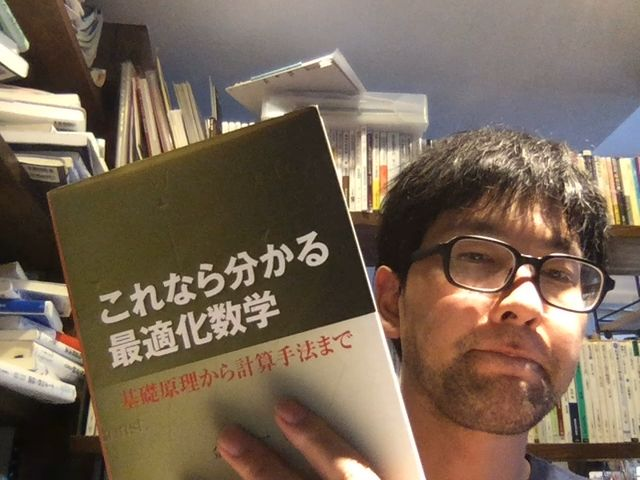

In [4]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [5]:
filename

'photo.jpg'

REDチャンネル


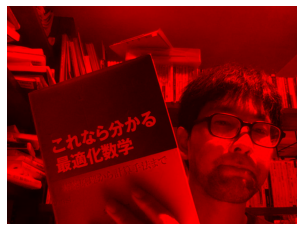

GREENチャンネル


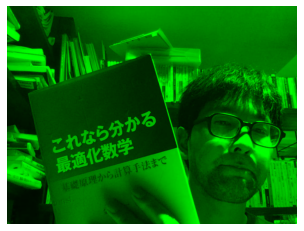

BLUEチャンネル


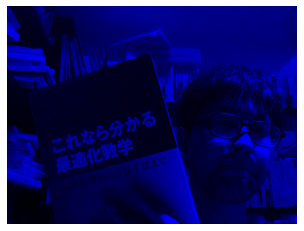

In [6]:
# https://konchangakita.hatenablog.com/entry/2021/01/15/210000
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import numpy as np

img = Image.open(filename)
img_array = np.asarray(img)  # (H, W, Ch)

def get_channel(image,channel='r'):
    # イメージをコピー
    new_image = image.copy()
    if channel=='r':
        # 「r」が指定された場合、「g」「b」は0にする
        new_image[:,:,1] = 0
        new_image[:,:,2] = 0
    elif channel=='g':
         # 「g」が指定された場合、「r」「b」は0にする
        new_image[:,:,0] = 0
        new_image[:,:,2] = 0
    elif channel=='b':
         # 「g」が指定された場合、「r」「b」は0にする
        new_image[:,:,0] = 0
        new_image[:,:,1] = 0
    return new_image


print("REDチャンネル")
image_2 = get_channel(img_array,channel='r')
plt.imshow( image_2 )
plt.axis("off")
plt.show()

print("GREENチャンネル")
image_2 = get_channel(img_array,channel='g')
plt.imshow( image_2 )
plt.axis("off")
plt.show()

print("BLUEチャンネル")
image_2 = get_channel(img_array,channel='b')
plt.imshow( image_2 )
plt.axis("off")
plt.show()

In [7]:
img_array.shape

(480, 640, 3)

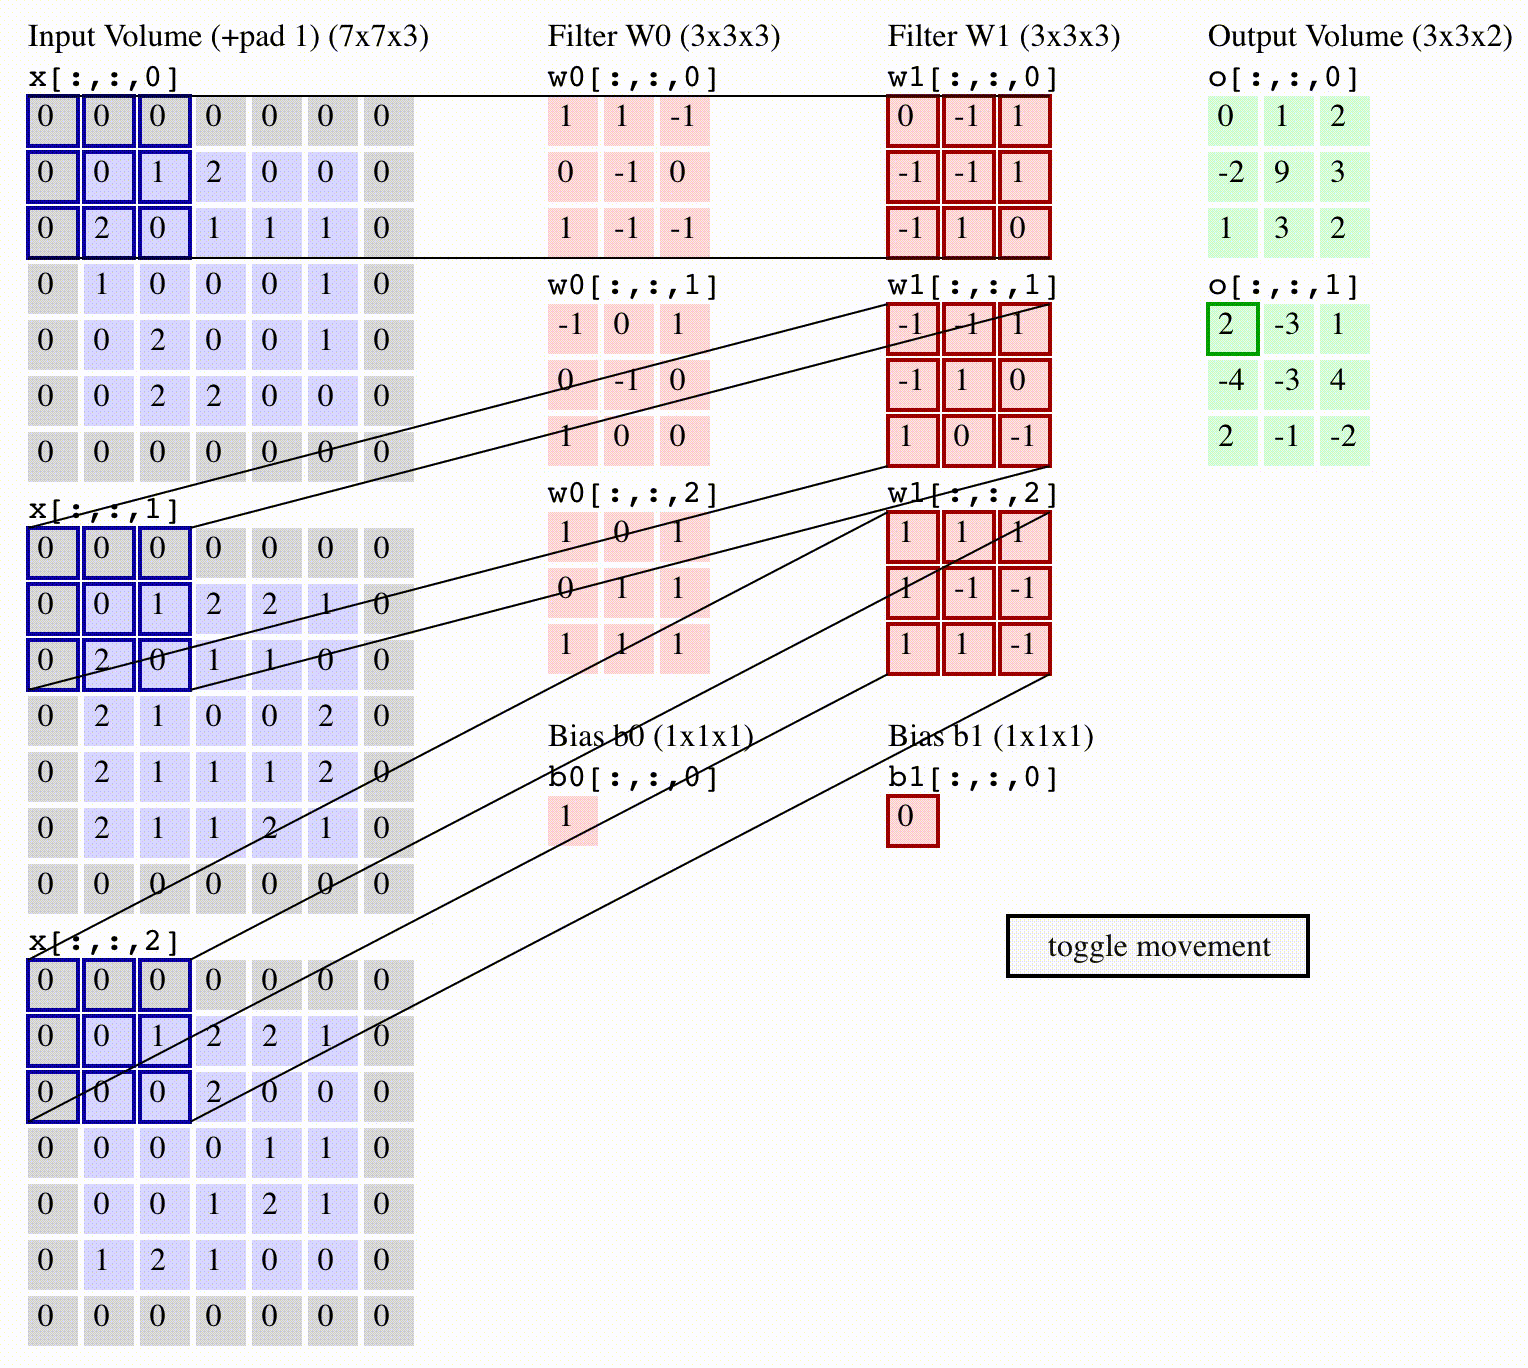

（図表出典：[CS231n Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/convolutional-networks/)）

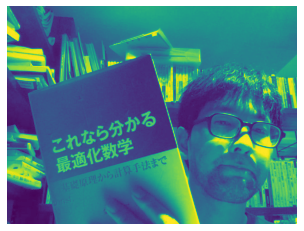

In [8]:
# grayスケールに変更
#gray_img = img_array[:,:,0] * 0.2989 + img_array[:,:,1] * 0.5870 + img_array[:,:,2] *  0.1140
gray_img = np.array(0.2989 * img_array[:,:,0] + 0.5870 * img_array[:,:,1] + 0.1140 * img_array[:,:,2], dtype='uint8')

plt.imshow(gray_img)
plt.axis("off")
plt.show()

In [9]:
!pip install -q torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html

# https://github.com/YutaroOgawa/pytorch_advanced/issues/71#issuecomment-622582464

     |████████████████████████████████| 748.9 MB 699 bytes/s 
     |████████████████████████████████| 8.8 MB 51.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.2.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.2.0 which is incompatible.
fastai 2.7.9 requires torch<1.14,>=1.7, but you have torch 1.2.0 which is incompatible.
fastai 2.7.9 requires torchvision>=0.8.2, but you have torchvision 0.4.0 which is incompatible.


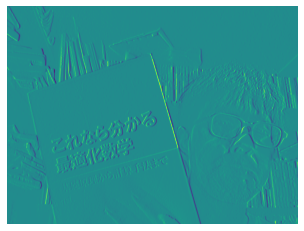

In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def zero_pad(img, pad):
    img_pad = np.pad(img, ((pad, pad), (pad, pad)), mode = 'constant', constant_values = (0, 0))

    return img_pad

def conv_filter(img, stride, padding, kernel):
    h, w = img.shape
    f, f = kernel.shape

    n_h = int(int(h + 2 * padding - f) / stride + 1)
    n_w = int(int(w + 2 * padding - f) / stride + 1)
    z = np.zeros([n_h, n_w])

    img_pad = zero_pad(img, padding)

    for h in range(n_h):
        vertical_start = stride * h
        verttical_end = vertical_start + f
        for w in range(n_w):
            horizontal_start = stride * w
            horizontal_end = horizontal_start + f
            target = img_pad[vertical_start:verttical_end, horizontal_start:horizontal_end]
            conv = np.multiply(target, kernel)
            conv_sum = np.sum(conv)
            z[h, w] = conv_sum

    return z


# filter
kernel_y = np.array([[-1, -2, -1],
                     [0,   0,  0],
                     [1,   2,  1]])

kernel_x = np.array([[-1, 0,  1],
                     [-2, 0,  2],
                     [-1, 0,  1]])

sobel_img = conv_filter(gray_img, stride = 1, padding = 0, kernel = kernel_x)
plt.imshow(sobel_img)
plt.axis("off")
plt.show()

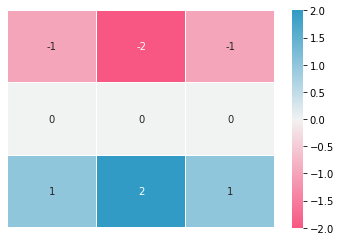

In [11]:
import seaborn as sns
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

sns.heatmap(kernel_y,  cmap=cmap, annot=True, fmt="d", linewidth=0.3)

plt.axis("off")
plt.show()

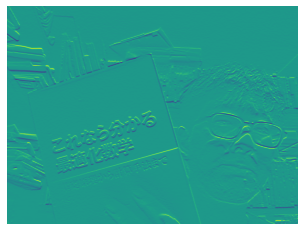

In [12]:
sobel_img = conv_filter(gray_img, stride = 1, padding = 0, kernel = kernel_y)
plt.imshow(sobel_img)
plt.axis("off")
plt.show()

In [13]:
def max_pool(img, factor: int):
    """ 
    Perform max pooling with a (factor x factor) kernel
    引用：https://stackoverflow.com/questions/42463172/how-to-perform-max-mean-pooling-on-a-2d-array-using-numpy
    """
    ds_img = np.full((img.shape[0] // factor, img.shape[1] // factor), -float('inf'), dtype=img.dtype)
    np.maximum.at(ds_img, (np.arange(img.shape[0])[:, None] // factor, np.arange(img.shape[1]) // factor), img)
    return ds_img

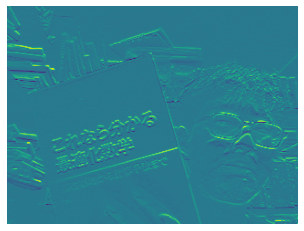

In [14]:
plt.imshow(max_pool(sobel_img , 2))
plt.axis("off")
plt.show()

In [15]:
  #@title SSDを取得
import os
from os.path import exists, join, basename, splitext

# git_repo_url = 'https://github.com/amdegroot/ssd.pytorch.git'
git_repo_url = 'https://github.com/midasklr/SSD.Pytorch.git'

project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
    # clone and install dependencies
    !git clone -q $git_repo_url
    # !wget https://raw.githubusercontent.com/miyamotok0105/pytorch_handbook/master/chapter7/layers/functions/detection.py && mv detection.py ssd.pytorch/layers/functions
    # !wget https://raw.githubusercontent.com/miyamotok0105/pytorch_handbook/master/chapter7/ssd.py && mv ssd.py ssd.pytorch/
  
import sys
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False


In [16]:
cd SSD.Pytorch

/content/SSD.Pytorch


In [17]:
#@title 学習済みのパラメータを取得する
PRETRAINED_MODEL_URL = 'https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth'

pretrained_model = basename(PRETRAINED_MODEL_URL)
if not exists(pretrained_model):
  !wget -q $PRETRAINED_MODEL_URL

In [18]:
# https://zenn.dev/nnabeyang/scraps/5800e9387debc2
from collections import OrderedDict
import torch

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd import build_ssd

new_weights = OrderedDict()
weight = torch.load(pretrained_model )
for (key, value) in weight.items():
    if key.startswith('vgg'):
        parts = key.split('.')
        parts[0] = 'base'
        key = '.'.join(parts)
    new_weights[key] = value
net = build_ssd('test', 300, 21)
net.load_state_dict(new_weights)

VGG base: [Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padd

<All keys matched successfully>

In [19]:
#@title 推論関数を用意

import random
import cv2
import numpy as np
from data import VOC_CLASSES as labels
colors = [[random.randint(0, 255) for _ in range(3)] for _ in labels]

net.eval()
torch.set_grad_enabled(False)

if torch.cuda.is_available():
  net = net.cuda()
# why?
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

# test on a given image, see: https://github.com/amdegroot/ssd.pytorch/blob/master/demo/demo.ipynb
def test(rgb_image, threshold=0.6):
  # resize to 300x300
  x = cv2.resize(rgb_image, (300, 300)).astype(np.float32)
  # image net mean substract
  x -= (123.0, 117.0, 104.0)
  # image tensor
  x = torch.from_numpy(x.astype(np.float32)).permute(2, 0, 1)
  x = x.unsqueeze(0)
  if torch.cuda.is_available():
    x = x.cuda()
  
  # forward
  t = time.time()
  detections = net(x)
  #print("executed in %.3fs" % (time.time()-t))
  
  # draw boxes and labels
  result_img = np.array(rgb_image)
  scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
  for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= threshold:
      score = detections[0,i,j,0]
      label = labels[i-1]
      display_txt = '%s: %.2f'%(label, score)
      pt = (detections[0,i,j,1:]*scale).cpu().numpy()
      color = colors[i-1]

      # draw box
      tl = round(0.002 * max(result_img.shape[0:2])) + 1  # line thickness
      c1, c2 = (int(pt[0]), int(pt[1])), (int(pt[2]), int(pt[3]))
      cv2.rectangle(result_img, c1, c2, color, thickness=tl)

      # draw text
      tf = max(tl - 1, 1)  # font thickness
      t_size = cv2.getTextSize(display_txt, 0, fontScale=tl / 3, thickness=tf)[0]
      c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
      cv2.rectangle(result_img, c1, c2, color, -1)  # filled
      cv2.putText(result_img, display_txt, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

      j+=1
      
  return result_img

/pytorch/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


conf_data size: torch.Size([1, 8732, 21])
conf_preds size: torch.Size([1, 21, 8732])


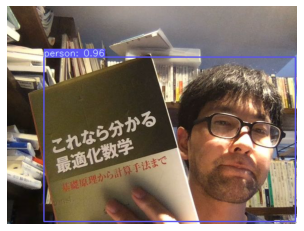

In [20]:
result_img = test(img_array)

plt.imshow(result_img)
plt.axis("off")
plt.show()

In [26]:
  threshold = 0.6

  # resize to 300x300
  x = cv2.resize(img_array, (300, 300)).astype(np.float32)
  # image net mean substract
  x -= (123.0, 117.0, 104.0)
  # image tensor
  x = torch.from_numpy(x.astype(np.float32)).permute(2, 0, 1)
  x = x.unsqueeze(0)
  if torch.cuda.is_available():
    x = x.cuda()
  
  # forward
  t = time.time()
  detections = net(x)
  #print("executed in %.3fs" % (time.time()-t))
  
  # draw boxes and labels
  result_img = np.array(img_array)
  scale = torch.Tensor(img_array.shape[1::-1]).repeat(2)
  for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= threshold:
      score = detections[0,i,j,0]
      label = labels[i-1]
      display_txt = '%s: %.2f'%(label, score)
      pt = (detections[0,i,j,1:]*scale).cpu().numpy()
      color = colors[i-1]

      # draw box
      tl = round(0.002 * max(result_img.shape[0:2])) + 1  # line thickness
      c1, c2 = (int(pt[0]), int(pt[1])), (int(pt[2]), int(pt[3]))
      cv2.rectangle(result_img, c1, c2, color, thickness=tl)

      # draw text
      tf = max(tl - 1, 1)  # font thickness
      t_size = cv2.getTextSize(display_txt, 0, fontScale=tl / 3, thickness=tf)[0]
      c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
      cv2.rectangle(result_img, c1, c2, color, -1)  # filled
      cv2.putText(result_img, display_txt, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

      j+=1

print("box", c1)

conf_data size: torch.Size([1, 8732, 21])
conf_preds size: torch.Size([1, 21, 8732])
box (81, 112)


/pytorch/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [68]:
#@title google colabとカメラを繋ぐ呪文 { display-mode: "form" }
import base64
import html
import io
import time

import IPython.display
from IPython.display import display, Javascript, clear_output
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2

def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_photo(label, img_data):
    data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))

    return  data

conf_data size: torch.Size([1, 8732, 21])
conf_preds size: torch.Size([1, 21, 8732])


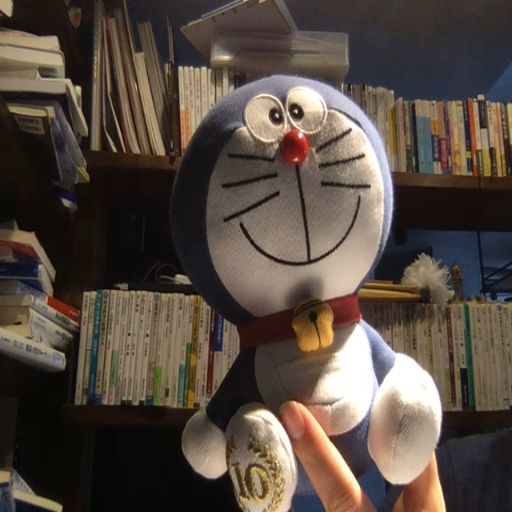

In [79]:
# https://colab.research.google.com/github/vindruid/yolov3-in-colab/blob/master/yolov3_streaming_webcam.ipynb#scrollTo=hZi6NXSDyAY6
# https://techzizou.com/train-a-custom-yolov4-detector-using-google-colab-tutorial-for-beginners/
start_input()
label_html = 'Capturing...'
img_data = ''

while True:
    try:
        _imge = js_reply_to_image(js_reply)
        _result = test(_imge)
        display(Image.fromarray(_result))
        clear_output(wait = True)
    except:
        print("")
    
    js_reply = take_photo(label_html, img_data)
    
    
    if not js_reply:
        break

In [55]:
_result.shape

(512, 512, 3)